In [13]:
from keras.models import Sequential,Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding,GRU,TimeDistributed,RepeatVector,Merge,BatchNormalization,Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Embedding,LSTM,GRU,TimeDistributed,RepeatVector,Merge,Input,merge,UpSampling2D
from keras.preprocessing import sequence
from keras import callbacks
from keras.optimizers import SGD, RMSprop, Adam

import numpy as np
from vgg16 import Vgg16
import matplotlib.pyplot as plt
import PIL.Image

from tqdm import tqdm

from utils import *

import cPickle as pickle
import string

import collections
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import re
from numpy.random import random, permutation, randn, normal 

import os

import preprocessing as preproc

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from matplotlib import animation
from IPython.display import display, HTML

import pandas as pd

import nnModel as nnModel

import videoExplorer as vidExplorer
import plotter
import languageUtils

In [2]:
def plot_movie_mp4(image_array):
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array), interval = 50)
    display(HTML(anim.to_html5_video()))


In [3]:
def get_unet(img_rows, img_cols,nr_labels):
    
    inputs = Input((3, img_rows, img_cols))
    bn = BatchNormalization()(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(bn)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(nr_labels, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [5]:
cat_2_supercat_dict = preproc.load_obj("/home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/detection/misc/cat_2_supercat_dict.pkl")
supercat2indexpath = "/home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/detection/misc/cat_2_index_dict_person_animal_vehicle_10e.pkl"
supercat_2_index_dict = preproc.load_obj(supercat2indexpath)

In [6]:
index_2_supercat_dict = dict([(vv,kk) for kk,vv in supercat_2_index_dict.iteritems()])

print(supercat_2_index_dict)
print(index_2_supercat_dict)

{'person': 0, 'animal': 1, 'vehicle': 2}
{0: 'person', 1: 'animal', 2: 'vehicle'}


In [7]:
def can_generate_segmentation(caption):
    caption_words = caption.split(" ")
    match_word_arr = [word in cat_2_supercat_dict for word in caption_words]
    found = np.any(match_word_arr)
    
    if(not found):
        return (False,-1)
    
    word_categories = np.array(caption_words)[np.array(match_word_arr)]
                                           
    if(len(word_categories) == 0):
        return (False,-1)
    
    category = word_categories[0]
   
    if(category not in cat_2_supercat_dict):
        return (False,-1)

    supercategory = cat_2_supercat_dict[category]

    if(supercategory not in supercat_2_index_dict):
        return (False,-1)
        
    return (True,supercat_2_index_dict[supercategory])

In [8]:
seg_net_model = get_unet(224,224,nr_labels = 3)
save_path = "/home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/detection/models/"
seg_net_model.load_weights(save_path+"person_animal_vehicle_10e.h5")

## Load images

In [37]:
val_path = base_path + val_folder
SMALL_NR_TEST_EXAMPLES = 1000

test_images_concat_t = preproc.get_images_concat(
    val_path + images_concat_folder+ 'images_concat_0.bc',
    SMALL_NR_TEST_EXAMPLES)

print(test_images_concat_t.shape)

(1000, 3, 224, 224)


## Load model

In [17]:
base_path = data_path+"app-100-length-15/"

(unique_words, word2index, index2word) = languageUtils.load_language_data_structures(base_path + general_datastruct_folder)
VOCAB_SIZE = len(unique_words)
MAX_CAPTION_LEN = 15
EMB_SIZE = 300

In [20]:
emb = nnModel.get_embeddings(index2word, VOCAB_SIZE, EMB_SIZE)
model = nnModel.build_model(emb,MAX_CAPTION_LEN, VOCAB_SIZE, EMB_SIZE)

model.load_weights(save_path + models_folder+"big/" +'app_100_length_15_past_word_20_epoch_300d_gru_2x1048_big.h5')

Found = 840
Not found = 8


## Make predictions per frame

In [41]:
window_start = 500
nr_images = 50
(images,predicted_captions) = nnModel.make_prediction_on_dataset(test_images_concat_t,model,word2index,index2word,MAX_CAPTION_LEN,window_start,nr_images)

100%|██████████| 50/50 [00:07<00:00, 11.34it/s]


In [42]:
seg_mask_to_supercat_list = [can_generate_segmentation(caption) for caption in predicted_captions]
seg_mask = [mask for (mask,_) in seg_mask_to_supercat_list]

In [43]:
seg_captions = np.asarray(predicted_captions)[np.asarray(seg_mask)]
seg_images = np.asarray(images)[np.asarray(seg_mask)]
image_supercat_list = [supercat for (_,supercat) in np.asarray(seg_mask_to_supercat_list)[np.asarray(seg_mask)]]

In [44]:
for i in range(5):
    print(seg_captions[i])
    print("\t ==>" + index_2_supercat_dict[image_supercat_list[i]])
    print("---")

A cat sitting on a desk in front of a computer
	 ==>animal
---
A train is parked on the tracks in a train station
	 ==>vehicle
---
A bus is parked on the side of the road
	 ==>vehicle
---
A dog is standing on the sidewalk near a building
	 ==>animal
---
A teddy bear is sitting on a rock
	 ==>animal
---


In [45]:
seg_images_np = np.stack(seg_images)
transposed_img = np.transpose(seg_images_np,(0,3,1,2))
transposed_img.shape

(13, 3, 224, 224)

In [46]:
predictions = seg_net_model.predict(transposed_img)
predictions.shape

(13, 3, 224, 224)

In [47]:
category_predictions = []
for index in range(len(predictions)):
    s_index = image_supercat_list[index]
    current_prediction = predictions[index]
    category_predictions.append(current_prediction[s_index:s_index+1,:,:])

In [48]:
def plotImageCaptionToMask(images, predictions, titles):
  
    nr_rows = len(predictions)
    
    figsize = 8
    plt.figure(figsize=(figsize,figsize))
    for index in range(nr_rows):
   
        squeezed_pred = np.squeeze(predictions[index])
        
        image = images[index]
        
        s_index = image_supercat_list[index]
        supercategory = index_2_supercat_dict[s_index]
        
        
        nr_cols = 2
        
        plt.subplot(1,nr_cols,1)
        plt.title(titles[index] + " => " + supercategory)
        plt.imshow(image)

        
        
        plt.subplot(1,nr_cols,2)

        plt.imshow(squeezed_pred)
        plt.imshow(image, alpha=0.5)
    
        
        plt.figure(figsize=(figsize,figsize))
        
    plt.show()

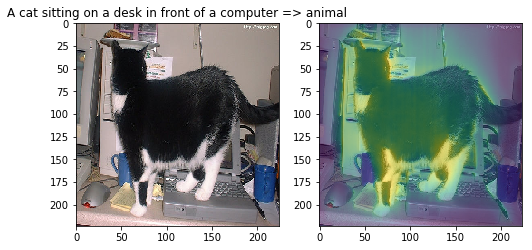

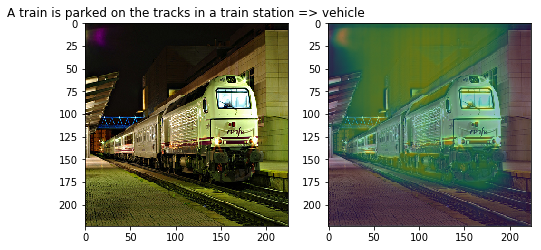

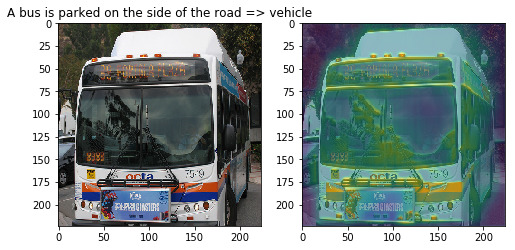

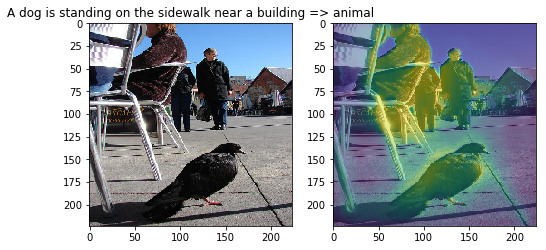

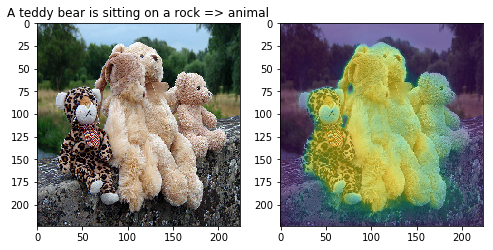

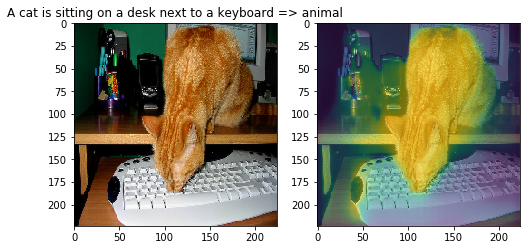

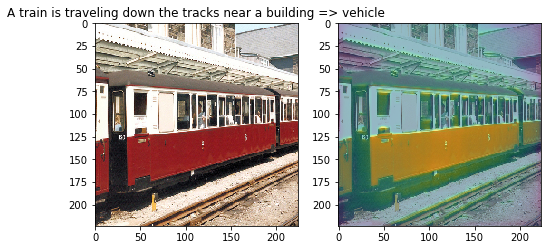

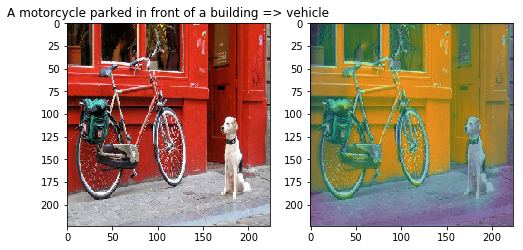

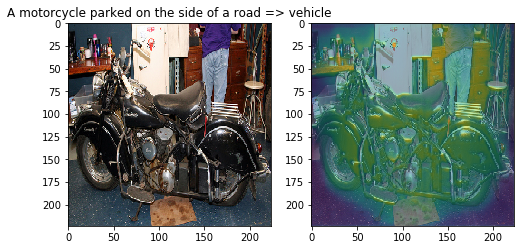

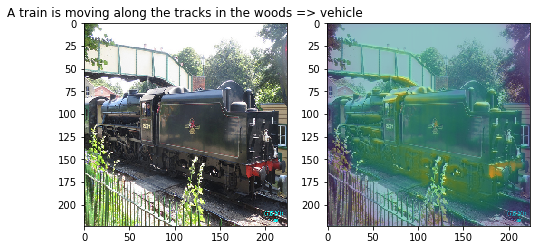

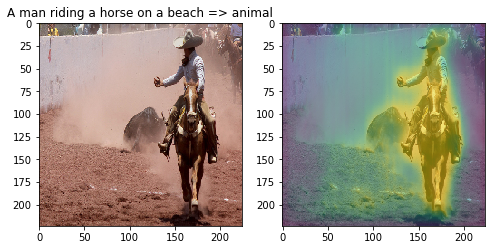

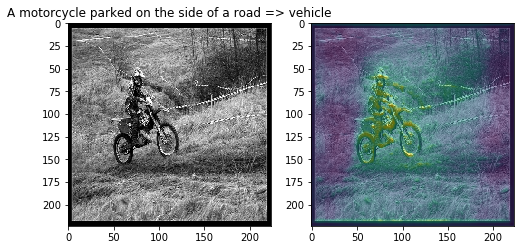

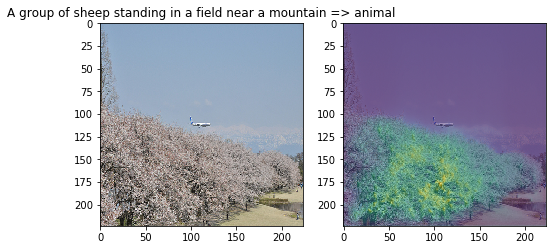

In [49]:
plotImageCaptionToMask(seg_images, category_predictions,seg_captions)

## Video Segmentation

In [ ]:
horse_path = "./horse.mp4"
video_frames = vidExplorer.get_mp4_vid_frames(horse_path)
video_frames.shape

In [32]:
predictions = seg_net_model.predict(video_frames)
predictions.shape

(287, 3, 224, 224)

In [33]:
animal_index = supercat_2_index_dict['animal']
animal_index

1

In [34]:
animal_preds = predictions[:,animal_index:animal_index+1,:,:]
animal_preds = np.squeeze(animal_preds)
animal_preds.shape

(287, 1, 224, 224)

In [ ]:
# plot_movie_mp4(video_frames)

In [36]:
plot_movie_mp4(animal_preds)